In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import math
from scipy import stats

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

      fun: -1.031628453489849
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.88178420e-08,  1.02140518e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 63
      nit: 10
     njev: 21
   status: 0
  success: True
        x: array([ 0.08984199, -0.71265634])


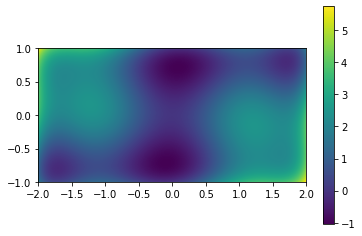

In [2]:
def func(params):
    x = params[0]
    y = params[1]
    return (4-2.1*pow(x,2)+pow(x,4)/3)*pow(x,2) + x*y + (4*pow(y,2)-4)*pow(y,2)

x_values = np.linspace(-2,2,1000)
y_values = np.linspace(-1,1,1000)

X,Y = np.meshgrid(x_values,y_values)

par = (X,Y)

Z = func(par)

res = optimize.minimize(func, [-2.0,-1.0],bounds=((-2,2),(-1,1)))

im = plt.imshow(Z,extent=[-2, 2, -1, 1])
plt.colorbar(im)

print(res)

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

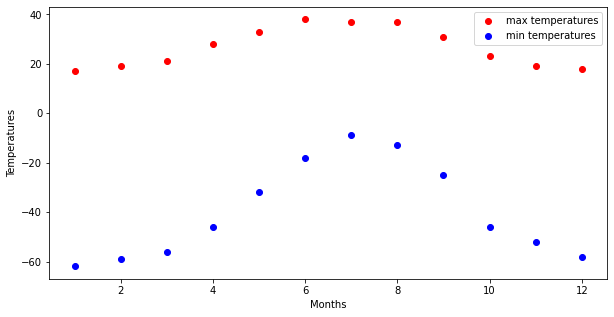

In [3]:
max_temp = np.array([17,19,21,28,33,38,37,37,31,23,19,18])
min_temp = np.array([-62,-59,-56,-46,-32,-18,-9,-13,-25,-46,-52,-58])

measured_time = np.arange(1,13,1)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(measured_time,max_temp, 'ro', label='max temperatures')
plt.plot(measured_time,min_temp, 'bo', label='min temperatures')
ax.set_xlabel('Months')
ax.set_ylabel('Temperatures')
plt.legend()
plt.show()

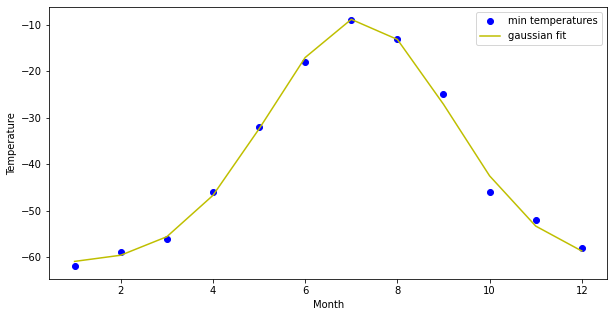

In [4]:
def gaussian(x, a, x0, sigma, d):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + d

mean_min = sum(measured_time * min_temp)/sum(min_temp)
sigma_min = np.sqrt(sum(min_temp * (measured_time - mean_min)**2) / sum(min_temp))

parameters_min, covariance_min = curve_fit(gaussian, measured_time, min_temp, p0 = [max(min_temp), mean_min, sigma_min,0])

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(measured_time,min_temp, 'bo', label='min temperatures')
plt.plot(measured_time, gaussian(measured_time, *parameters_min), 'y-', label='gaussian fit')
ax.set_xlabel('Month')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

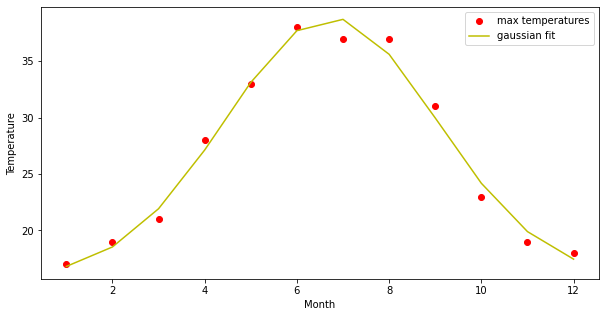

In [5]:
mean_max = sum(measured_time * max_temp)/sum(max_temp)
sigma_max = np.sqrt(sum(max_temp * (measured_time - mean_max)**2) / sum(max_temp))

parameters_max, covariance_max = curve_fit(gaussian, measured_time, max_temp, p0 = [max(max_temp), mean_max, sigma_max,0])

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(measured_time,max_temp, 'ro', label='max temperatures')
plt.plot(measured_time, gaussian(measured_time, *parameters_max), 'y-', label='gaussian fit')
ax.set_xlabel('Month')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

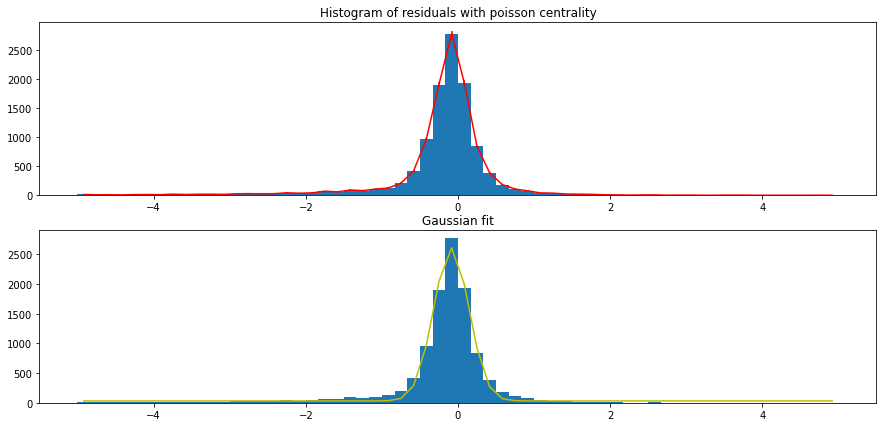

In [6]:
import pickle

with open('data/residuals_261.pkl', 'rb') as f:
    data = pickle.load(f)

df = pd.DataFrame(data.item(0))
res = df['residuals'].to_numpy()

fig,(h1,h2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15,7))
h,bins,_ = h1.hist(df['residuals'], bins = 60, range = (-5,5))
bin_centres = (bins[:-1] + bins[1:])/2.

sig_y = np.sqrt(np.abs(h))
h1.errorbar(x = bin_centres, y = h, yerr=sig_y, color="red")
h1.set_title("Histogram of residuals with poisson centrality")


parameters, covariance = curve_fit(gaussian, bin_centres, h)

gaussian_fit = gaussian(bin_centres, *parameters)

h2.plot(bin_centres, gaussian(bin_centres, *parameters), 'y-', label='gaussian fit')
h2.hist(df['residuals'], bins = 60, range = (-5,5))
h2.set_title("Gaussian fit")
plt.show()

In [13]:
statistic,p = stats.chisquare(h, gaussian_fit)
print("p value founded: ",p)
print("The p value is too small, so the fit is not satisfactory")

p value founded:  0.0
The p value is too small, so the fit is not satisfactory


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

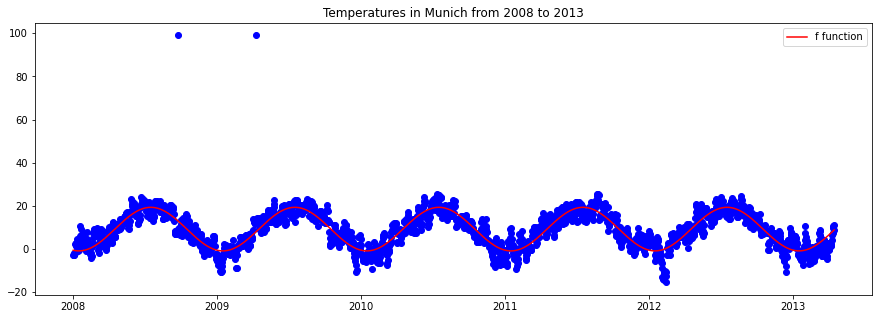

In [8]:
def f_function(t,a,b,c):
    return a*np.cos(2*math.pi*t + b) + c

with open('data/munich_temperatures_average_with_bad_data.txt', 'r') as f:
    df = pd.read_csv(f, sep=" ", header=None)
    df.columns = ["date", "temperature"]
    
data_range = df[(df['date']>=2008)&(df['temperature']<=2012)]

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(data_range['date'],data_range['temperature'], 'bo')
ax.set_title("Temperatures in Munich from 2008 to 2013")
parameters,_ = curve_fit(f_function, data_range['date'], data_range['temperature'])
f_fit = f_function(data_range['date'],parameters[0],parameters[1],parameters[2])
ax.plot(data_range['date'],f_fit,'r-', label="f function")
ax.legend()
plt.show()

In [9]:
print("All the following measures are based on the period from 2008 to 2013")
print("Overall average temperature in Munich: ",data_range['temperature'].mean())
print("Coldest value predicted in the year: ",max(f_fit))
print("Hottest value predicted in the year: ",min(f_fit))
print("The b value is needed to move the function to one direction")

All the following measures are based on the period from 2008 to 2013
Overall average temperature in Munich:  8.878905848575867
Coldest value predicted in the year:  19.35484356446377
Hottest value predicted in the year:  -0.8319839003074314
The b value is needed to move the function to one direction


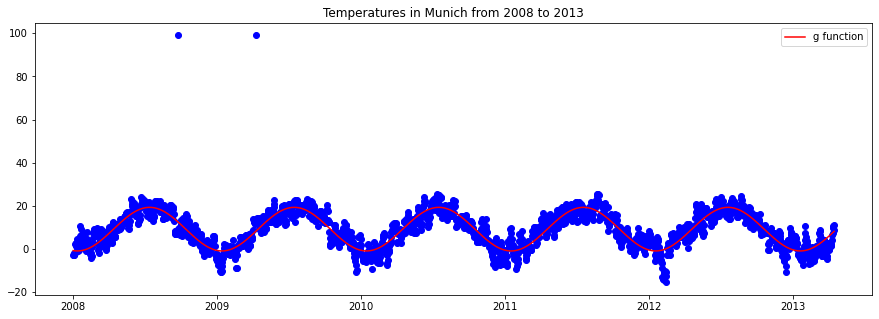

In [10]:
def g_function(t,a,b,c,d):
    return a*np.cos(2*math.pi*b*t + c) + d

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(data_range['date'],data_range['temperature'], 'bo')
ax.set_title("Temperatures in Munich from 2008 to 2013")
parameters,_ = curve_fit(g_function, data_range['date'], data_range['temperature'])
g_fit = g_function(data_range['date'],parameters[0],parameters[1],parameters[2],parameters[3])
ax.plot(data_range['date'],g_fit,'r-', label="g function")
ax.legend()
plt.show()

In [11]:
RSS_1 = sum(np.square(data_range['temperature']-f_fit))
RSS_2 = sum(np.square(data_range['temperature']-g_fit))
print('RSS of function f: ', RSS_1)
print('RSS of function g: ', RSS_2)

RSS of function f:  42527.759651670036
RSS of function g:  42410.17254142675


In [12]:
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

Ftest(RSS_1,RSS_2,4,5,100, verbose=True)

CL: 0.609 , additional parameter necessary: NO


0.6089863748918102